In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonfflynn","key":"620de0050762552556db28d497951638"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats
! unzip dogs-vs-cats.zip
# ! unzip train.zip > /dev/null

 98% 797M/812M [00:03<00:00, 274MB/s]
100% 812M/812M [00:03<00:00, 264MB/s]
Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [4]:
# ! rm -rf train.zip
! rm -rf sampleSubmission.csv
! rm -rf test1.zip
! rm -rf dogs-vs-cats.zip

In [5]:
from PIL import Image
import io
import zipfile

import numpy as np
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns

In [6]:
torch.random.manual_seed(42)
np.random.seed(42)

In [7]:
label_str = ['cat', 'dog']

In [8]:
def preprocess(input_zip, size=(128, 128)):
    images_processed = []

    with zipfile.ZipFile(input_zip, 'r') as archive_zip:
        archives = archive_zip.namelist()
        images = []
        labels = []
        for i, archive in enumerate(archives):
            if archive.endswith(('.png', '.jpg', '.jpeg')):
                images.append(archive)
                if 'cat' in archive:
                    labels.append(0)
                if 'dog' in archive:
                    labels.append(1)
        # images = [archive for archive in archives if archive.endswith(('.png', '.jpg', '.jpeg'))]
        imgs = []
        for img_path in tqdm(images):
            with archive_zip.open(img_path) as image_zip:
                img = Image.open(io.BytesIO(image_zip.read()))


                imgs.append(img)
                # images_processed.append(img_array)

    # dataset = np.array(images_processed)

    return imgs, np.array(labels)

In [16]:
class Cat_dog_dataset(Dataset):
    def __init__(self, cat_and_dog_images, labels, transform=None):
        self.transform = transform
        self.images = cat_and_dog_images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
cat_and_dog_images, labels = preprocess('train.zip')

100%|██████████| 25000/25000 [00:05<00:00, 4794.20it/s]


In [17]:
cat_dog_dataset = Cat_dog_dataset(cat_and_dog_images=cat_and_dog_images, labels=labels, transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

]))

In [45]:
train_real_dataset, test_dataset = train_test_split(cat_dog_dataset, test_size=0.3, random_state=42)
train_real_dataloader = DataLoader(train_real_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
fake_cat_and_dog, fake_label = preprocess('/content/fake_data.zip')

In [ ]:
from torchvision import models

In [ ]:
fake_dataset = Cat_dog_dataset(fake_cat_and_dog, fake_label, transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

]))

In [21]:
train_loader_fake = DataLoader(fake_dataset, batch_size=32, shuffle=False)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
def train_model(model, train_loader,train_fake_loader, test_loader, loss_fn, optimizer, num_epochs=150):
    losses = []
    test_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()

        with tqdm(total=(len(train_loader) + len(train_fake_loader)), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                labels.long()

                optimizer.zero_grad()

                outputs = model(inputs)
                # print(type(outputs),labels)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=f'{loss.item():.4f}')
                pbar.update()

            for batch_idx, (inputs, labels) in enumerate(train_fake_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                labels.long()

                optimizer.zero_grad()

                outputs = model(inputs)

                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=f'{loss.item():.4f}')
                pbar.update()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss/len(test_loader))
        losses.append(running_loss/(len(train_loader) + len(train_fake_loader)))

        tqdm.write(f'Train Loss: {running_loss/(len(train_loader) + len(train_fake_loader)):.4f} | 'f'Test Loss: {test_loss/len(test_loader):.4f}')



        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/model_checkpoint/classifier_B_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/model_checkpoint/classifier_B_end.pth')
    return losses, test_losses



In [47]:
from torchvision import models
classifier_B = models.resnet18(pretrained=True)
for param in classifier_B.parameters():
    param.requires_grad = False

for param in classifier_B.fc.parameters():
    param.requires_grad = True

for param in classifier_B.layer4.parameters():
    param.requires_grad = True

for param in classifier_B.layer3.parameters():
    param.requires_grad = True
num_ftrs = classifier_B.fc.in_features
classifier_B.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_B = classifier_B.to(device)

In [48]:
losses, test_losses = train_model(model=classifier_B,
                                  train_loader=train_real_dataloader,
                                  train_fake_loader=train_loader_fake,
                                  test_loader=test_dataloader,
                                  loss_fn=nn.CrossEntropyLoss(),
                                  optimizer=optim.Adam(classifier_B.parameters(), lr=0.0005),
                                  num_epochs=30)

Epoch 1/30: 100%|██████████| 579/579 [00:10<00:00, 54.23batch/s, loss=0.0978]


Train Loss: 0.2176 | Test Loss: 0.1481


Epoch 2/30: 100%|██████████| 579/579 [00:10<00:00, 54.43batch/s, loss=0.1643]


Train Loss: 0.1152 | Test Loss: 0.1480


Epoch 3/30: 100%|██████████| 579/579 [00:10<00:00, 54.41batch/s, loss=0.2261]


Train Loss: 0.0702 | Test Loss: 0.1527


Epoch 4/30: 100%|██████████| 579/579 [00:10<00:00, 53.68batch/s, loss=0.4082]


Train Loss: 0.0511 | Test Loss: 0.2409


Epoch 5/30: 100%|██████████| 579/579 [00:10<00:00, 53.35batch/s, loss=0.1704]


Train Loss: 0.0401 | Test Loss: 0.1515


Epoch 6/30: 100%|██████████| 579/579 [00:10<00:00, 53.37batch/s, loss=0.1365]


Train Loss: 0.0295 | Test Loss: 0.1599


Epoch 7/30: 100%|██████████| 579/579 [00:10<00:00, 53.94batch/s, loss=0.1382]


Train Loss: 0.0330 | Test Loss: 0.1574


Epoch 8/30: 100%|██████████| 579/579 [00:10<00:00, 53.78batch/s, loss=0.3017]


Train Loss: 0.0287 | Test Loss: 0.2655


Epoch 9/30: 100%|██████████| 579/579 [00:10<00:00, 54.03batch/s, loss=0.1807]


Train Loss: 0.0216 | Test Loss: 0.2021


Epoch 10/30: 100%|██████████| 579/579 [00:10<00:00, 53.78batch/s, loss=0.3540]


Train Loss: 0.0262 | Test Loss: 0.1565


Epoch 11/30: 100%|██████████| 579/579 [00:10<00:00, 53.62batch/s, loss=0.0722]


Train Loss: 0.0201 | Test Loss: 0.1913


Epoch 12/30: 100%|██████████| 579/579 [00:10<00:00, 54.25batch/s, loss=0.0532]


Train Loss: 0.0190 | Test Loss: 0.1916


Epoch 13/30: 100%|██████████| 579/579 [00:10<00:00, 53.65batch/s, loss=0.1817]


Train Loss: 0.0154 | Test Loss: 0.1759


Epoch 14/30: 100%|██████████| 579/579 [00:10<00:00, 54.10batch/s, loss=0.1014]


Train Loss: 0.0169 | Test Loss: 0.2119


Epoch 15/30: 100%|██████████| 579/579 [00:10<00:00, 54.05batch/s, loss=0.0442]


Train Loss: 0.0164 | Test Loss: 0.1738


Epoch 16/30: 100%|██████████| 579/579 [00:10<00:00, 53.64batch/s, loss=0.0200]


Train Loss: 0.0164 | Test Loss: 0.1607


Epoch 17/30: 100%|██████████| 579/579 [00:10<00:00, 54.24batch/s, loss=0.0749]


Train Loss: 0.0119 | Test Loss: 0.4006


Epoch 18/30: 100%|██████████| 579/579 [00:10<00:00, 53.68batch/s, loss=0.0145]


Train Loss: 0.0138 | Test Loss: 0.1764


Epoch 19/30: 100%|██████████| 579/579 [00:10<00:00, 53.67batch/s, loss=0.0842]


Train Loss: 0.0136 | Test Loss: 0.1943


Epoch 20/30: 100%|██████████| 579/579 [00:10<00:00, 53.25batch/s, loss=0.0925]


Train Loss: 0.0126 | Test Loss: 0.1879


Epoch 21/30: 100%|██████████| 579/579 [00:10<00:00, 53.49batch/s, loss=0.1405]


Train Loss: 0.0112 | Test Loss: 0.2333


Epoch 22/30: 100%|██████████| 579/579 [00:10<00:00, 54.10batch/s, loss=0.0384]


Train Loss: 0.0102 | Test Loss: 0.1852


Epoch 23/30: 100%|██████████| 579/579 [00:10<00:00, 53.82batch/s, loss=0.0035]


Train Loss: 0.0068 | Test Loss: 0.2471


Epoch 24/30: 100%|██████████| 579/579 [00:10<00:00, 53.70batch/s, loss=0.1274]


Train Loss: 0.0123 | Test Loss: 0.2319


Epoch 25/30: 100%|██████████| 579/579 [00:10<00:00, 53.65batch/s, loss=0.1210]


Train Loss: 0.0087 | Test Loss: 0.2073


Epoch 26/30: 100%|██████████| 579/579 [00:10<00:00, 53.90batch/s, loss=0.1587]


Train Loss: 0.0090 | Test Loss: 0.2378


Epoch 27/30: 100%|██████████| 579/579 [00:10<00:00, 53.87batch/s, loss=0.0641]


Train Loss: 0.0066 | Test Loss: 0.2871


Epoch 28/30: 100%|██████████| 579/579 [00:10<00:00, 53.54batch/s, loss=0.0382]


Train Loss: 0.0094 | Test Loss: 0.2142


Epoch 29/30: 100%|██████████| 579/579 [00:10<00:00, 53.57batch/s, loss=0.0367]


Train Loss: 0.0077 | Test Loss: 0.1858


Epoch 30/30: 100%|██████████| 579/579 [00:10<00:00, 53.74batch/s, loss=0.0369]


Train Loss: 0.0086 | Test Loss: 0.2510


In [49]:
def plot_loss(losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/figures/loss.png')
    plt.show()

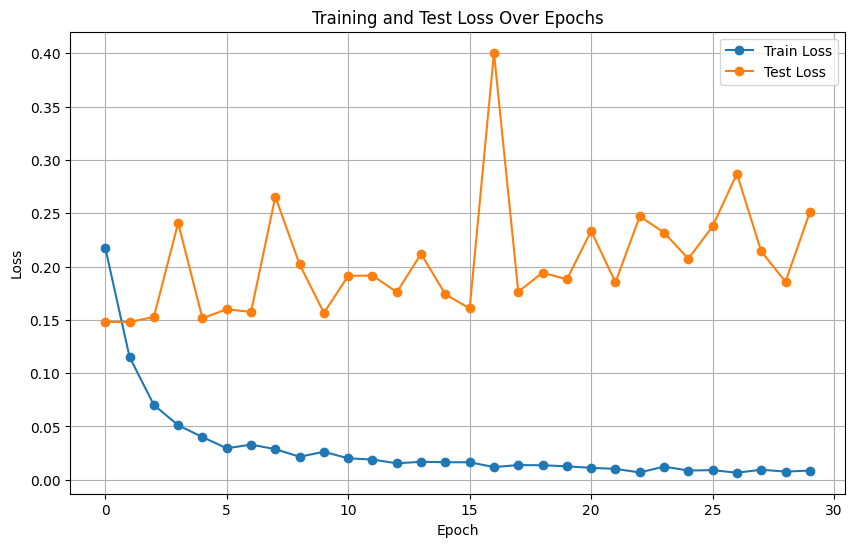

In [50]:
plot_loss(losses, test_losses)

In [51]:
def test_model(model, test_loader):
    model.eval()


    all_preds = []
    all_labels = []
    loss_test = 0.0
    running_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()


    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    return all_preds, all_labels

In [52]:
pred_res, labels_res = test_model(classifier_B, test_loader=test_dataloader)

100%|██████████| 235/235 [00:01<00:00, 165.62it/s]


In [36]:
def evaluate_classifier(predictions: np.ndarray, labels: np.ndarray):
    """
    Evaluate a binary classifier.

    Parameters:
        predictions (np.ndarray): Predicted labels (0 or 1).
        labels (np.ndarray): True labels (0 or 1).

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)

    # For AUC, we need probability estimates (assuming binary classification)
    # If predictions are not probabilities, we can set them as dummy values
    # Here, we assume the predictions are 0 and 1, you need to adjust according to your model's output.
    if np.unique(predictions).size == 2:  # Only if we have both classes
        # Dummy probability scores for AUC calculation (assumed 0.5 for incorrect predictions)
        dummy_probabilities = np.where(predictions == 1, 0.9, 0.1)  # You may adjust this
        auc = roc_auc_score(labels, dummy_probabilities)
    else:
        auc = None  # Cannot compute AUC if there's only one class in predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)

    # Print classification report
    print(classification_report(labels, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'confusion_matrix': cm
    }

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3752
           1       0.97      0.91      0.94      3748

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



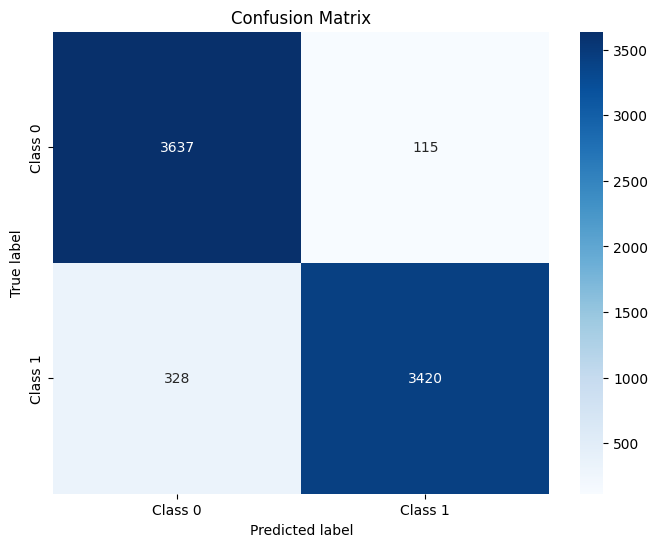

{'accuracy': 0.9409333333333333,
 'f1_score': 0.9391734175477139,
 'precision': 0.9674681753889675,
 'recall': 0.9124866595517609,
 'auc': 0.9409181698611682,
 'confusion_matrix': array([[3637,  115],
        [ 328, 3420]])}

In [53]:
evaluate_classifier(pred_res, labels_res)

In [54]:


def plot_images_with_labels(images, pred_labels, true_labels, figsize=(12, 12)):

    temp_s = 0
    indices = []
    for i in range(len(pred_labels)):
        if pred_labels[i] != true_labels[i]:
            indices.append(i)
            temp_s += 1
        if temp_s > 7:
            break

    num_images = len(indices)
    rows = 2
    cols = (num_images // rows) + (num_images % rows > 0)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        img = test_dataset[idx][0].permute(1, 2, 0).numpy()
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        elif img.dtype == np.int32 or img.dtype == np.int64:
            img = np.clip(img, 0, 255).astype(np.uint8)
        ax.imshow(img)
        ax.axis('off')

        title = f"True: {label_str[true_labels[idx]]}\nPred: {label_str[pred_labels[idx]]}"
        ax.set_title(title, color=("green" if true_labels[idx] == pred_labels[idx] else "red"))


    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

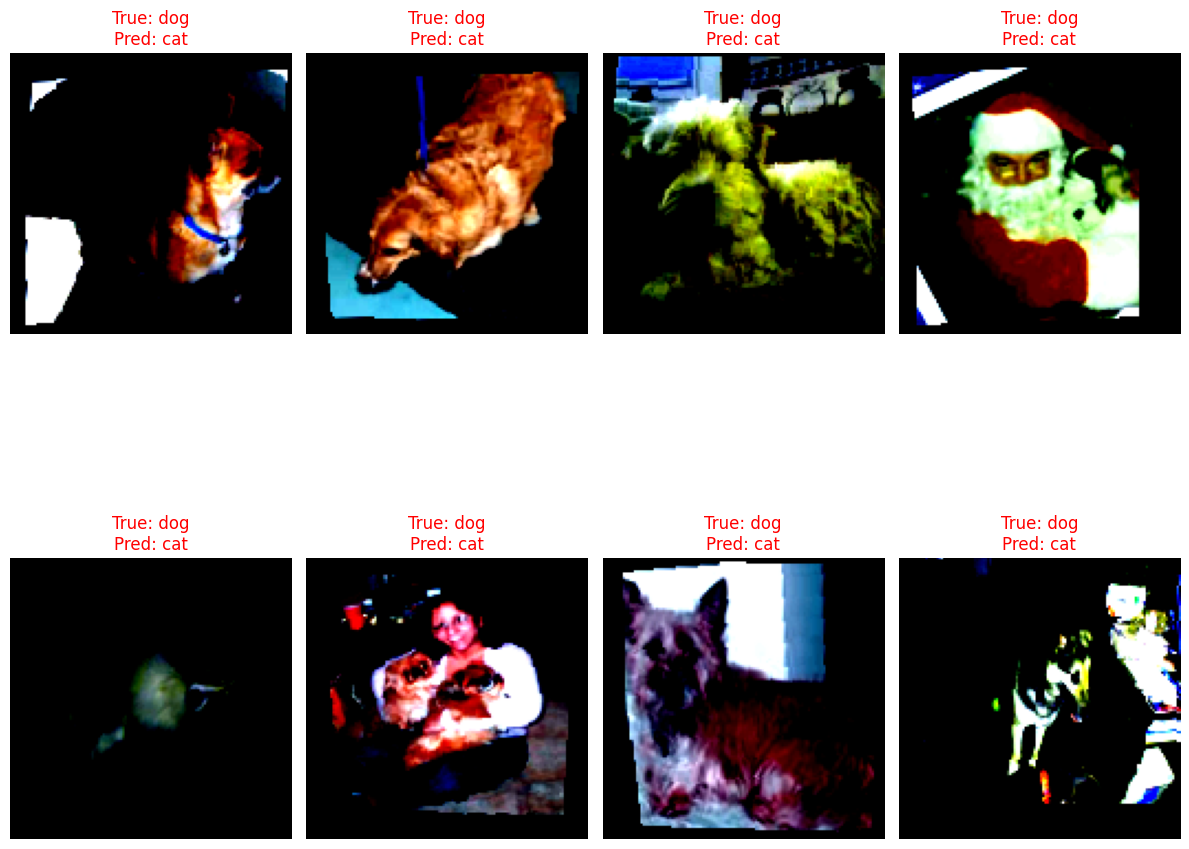

In [55]:
plot_images_with_labels(test_dataset, pred_res, labels_res)